<a href="https://colab.research.google.com/github/aamini/introtodeeplearning_labs/blob/lab3/lab3/Lab3_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 3: Reinforcement Learning

FIXED? Reinforcement learning (RL) is a subset of machine learning which poses learning problems as interactions between agents and environments. It often assumes agents have no prior knowledge of the given world, so they must learn to navigate environments by optimizing some provided reward function. Within a world, an agent can take certain actions and receive feedback--in the form of positive or negative rewards--with respect to their decision. As such, an agent's feedback loop is somewhat akin to the manner in which a child might learn to distinguish between "good" and "bad" actions. In practical terms, our RL agent will interact with the environment by taking an action at each timestep, receiving a corresponding reward, and updating its state according to what it's "learned".  

![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

## Why do we care about games? 
While the ultimate goal of reinforcement learning is to teach agents to act in the real, physical world, games provide a set of very useful properties that we also care about: 

1.   In many cases, games have perfectly describable enviornments. For example, all rules of chess can be formally written and programmed into a chess game simulator;
2.   Massively parallelizable. Do not require running in the real world, therefore simultaneous environments can be run on large data clusters; 
3.   Fast prototyping of algorithms on simpler scenarios can speed up the development of algorithms that could eventually run in the real-world; and
4.   ... Games are fun! 

In this lab, we focus on building a model-free reinforcement learning algorithm to master two different enviornments with varying complexity. 

1.   **Cartpole:   Balance a pole in an upright position by only moving your base left or right. Low-dimensional observation space.**
2.   **Pong:   Beat a classical AI system designed at the game of Pong. High-dimensional observational space -- learning directly from raw pixels!  **


#Part 1: Cartpole

FIXED? Since we're no longer dealing with a supervised learning task, let's take a step back and outline our approach to the problem. First, we'll need to create our environment and initialize our agent. Moreover, we'll need to provide our agent with some sort of mechanism for remembering action and reward history with its environment it to be able to learn from it... in other words, a memory bank. Then we'll need to define our learning algorithm, much like we've done in previous labs.

FIXME: IMAGE OF PIPELINE/WORKFLOW


First we'll import TensorFlow, enable Eager execution, and also import some dependencies.

In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

import tensorflow as tf
tf.enable_eager_execution()


import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time

# Download the class repository
! git clone https://github.com/aamini/introtodeeplearning_labs.git  > /dev/null 2>&1
% cd introtodeeplearning_labs 
! git pull
% cd .. 

import introtodeeplearning_labs as util

/content/introtodeeplearning_labs
Already up to date.
/content


### 1.1 Define and inspect the environment

FIXED? In order to model our environment, we'll be using a toolkit developed by OpenAI, [OpenAI Gym](https://gym.openai.com/). It provides several pre-defined environments for training and testing reinforcement learning agents, including those for classic physics control tasks, Atari video games, and robotic simulations. To access the basic version of a control task, "Cart Pole", we can use `env = gym.make("CartPole-v0")`. When we imported `gym`, we gained access to higher level functions in the package, including creating virtual worlds. Each environment has a specific identifier (for which you can read through [here](https://gym.openai.com/envs/#classic_control)) which is accessed by encasing the environment name with string quotes.
One issue we might experience when developing RL algorithms is that many aspects of the larning process are inherently random: initializing game states, changes in the environment, and the agent's actions. As such, it can be helpful to set a random "seed" for one of these variables to ensure some level of reproducibility. Much like you might use `numpy.random.seed`, we can call the comparable function in gym, `seed`, with our defined environment to ensure the environment's random variables are initialized the same each time. 

In [3]:
env = gym.make("CartPole-v0")
env.seed(1) # reproducible, since RL has high variance

/usr/local/lib/python2.7/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[1L]

FIXME: more background text on the observation space. Can include a schematic image of cart-pole control such as this one: https://danielpiedrahita.wordpress.com/portfolio/cart-pole-control/

Observations:

1. position of cart
2. velocity of cart
3. angle of pole
4. rotation rate of pole

We can confirm the size of the space by querying the observation space


In [4]:
print "Enviornment has observation space = {}".format(env.observation_space)

Enviornment has observation space = Box(4,)


FIXME: can also have a schematic imager her indicating the agents action space. 

At every time step, the agent can move either right or left. Again, we can confirm the size of the action space again by querying the environment

In [5]:
n_actions = env.action_space.n
print "Number of possible actions that the agent can choose from = {}".format(n_actions)

Number of possible actions that the agent can choose from = 2


### 1.2 Define the Agent

Let's define our agent, which is simply a deep neural network which takes as input an observation of the enviornment and outputs the probability of taking each of the possible actions. 

FIXME: schematic/figure defintely helpful here, esp if did not include the cart pull example. 


In [0]:
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=n_actions, activation=None)
  ])
  return model

cartpole_model = create_cartpole_model()

Define the action function that executes a forward pass through the network and samples from the output. Take special note of the output activation of the model.

In [0]:
def choose_action(model, observation):
    
  observation = observation.reshape([1, -1])
  logits = model.predict(observation)

  prob_weights = tf.nn.softmax(logits).numpy()

  action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]

  return action

### 1.3 Create the agent's memory

During training, the agent will need to remember all of its observations, actions so that once the episode ends, it can "reinforce" the good actions and punish the undesirable actions. Let's do this by defining a simple memory buffer that contains the agent's observations, actions, and received rewards from a given episode. 

In [0]:
class Memory:
  def __init__(self): 
      self.clear()

  def clear(self): 
      self.observations = []
      self.actions = []
      self.rewards = []

  def add_to_memory(self, new_observation, new_action, new_reward): 
      self.observations.append(new_observation)
      self.actions.append(new_action)
      self.rewards.append(new_reward)
        
memory = Memory()

We're almost ready to begin the learning algorithm for our agent! The final step is to compute the discounted rewards of our agent. Recall from lecture, we use reward discount to give more preference at getting rewards now rather than later in the future. The idea of discounting rewards is similar to discounting money in the case of interest and can be defined as: 

FIXME: put the equation for discounted rewards here -- structure the equation similar to the code so we can ask students to complete the code given the equations


In [0]:
def normalize(x):
  x -= np.mean(x)
  x -= np.std(x)
  return x

def discount_rewards(rewards, gamma=0.95): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

### 1.4 Define the learning algorithm

FIXME: preface with some general sentence about RL learnin and optimization.
Start by defining the optimizer we want to use.

In [0]:
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)

And now let's define the loss function. In this lab we are focusing on policy gradient methods which aim to **maximize** the likelihood of actions that result in large rewards. Equivalently, this means that we want to **minimize** the negative likelihood of these same actions. Like in supervised learning, we can use stochastic gradient descent methods to achieve this minimization. 

Since the log function is monotonically increasing, this means that minimizing negative **likelihood** is equivalent to minimizing negative **log-likelihood**.  Recall that we can easily compute the negative log-likelihood of an discrete action by evaluting its softmax cross entropy (https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits) 

In [0]:
def compute_loss(logits, actions, rewards): 
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
  loss = tf.reduce_mean( neg_logprob * rewards )
  return loss

Now let's use the loss function to define a backpropogation step of our learning algorithm.

In [0]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
      # Forward propogate through the agent
      observations = tf.convert_to_tensor(observations, dtype=tf.float32)
      logits = model(observations)

      # Compute the loss
      loss = compute_loss(logits, actions, discounted_rewards)

  # Backpropagation
  grads = tape.gradient(loss, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())

### 1.5 Let the agent go and watch it learn from scratch!

Having had no prior knowledge of the environment, the agent will begin to learn how to balance the pole on the cart based only on the feedback received from the environment! Having defined how our agent can move, how it takes in new observations, and how it updates its state, we'll see how it gradually learns a policy of actions to optimize balancing the pole as long as possible.



In [0]:
cartpole_model = create_cartpole_model()

smoothed_reward = util.LossHistory(smoothing_factor=0.9)
plotter = util.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')


for i_episode in range(1000):

  plotter.plot(smoothed_reward.get())

  # Restart the environment
  observation = env.reset()

  while True:
      action = choose_action(cartpole_model, observation)
      next_observation, reward, done, info = env.step(action)
      memory.add_to_memory(observation, action, reward)

      if done:
          total_reward = sum(memory.rewards)
          smoothed_reward.append( total_reward )

          train_step(cartpole_model, 
                     optimizer, 
                     observations = np.vstack(memory.observations),
                     actions = np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))
          
          memory.clear()
          break

      observation = next_observation

### 1.6 Save a video of the trained model while it is balancing the pole

In [0]:
def save_video_of_model(model, env_name, filename='agent.mp4'):  
  import skvideo.io
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(40, 30))
  display.start()

  env = gym.make(env_name)
  obs = env.reset()
  shape = env.render(mode='rgb_array').shape[0:2]

  out = skvideo.io.FFmpegWriter(filename)

  done = False
  while not done: 
      frame = env.render(mode='rgb_array')
      out.writeFrame(frame)
      
      action = model(tf.convert_to_tensor(obs.reshape((1,-1)), tf.float32)).numpy().argmax()
      obs, reward, done, info = env.step(action)
  out.close()
  print "Successfully saved into {}!".format(filename)

save_video_of_model(cartpole_model, "CartPole-v0")

Successfully saved into agent.mp4!


### 1.7 Display the saved video


In [0]:
from IPython.display import HTML
import io, base64
video = io.open('./agent.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

Congratulations, well done! How does the agent perform? Could you train it for shorter amounts of time and still perform well? Would training longer help even more? 

#Part 2: Pong

In Cart Pole, we dealt with an environment that was static--in other words, it didn't change over time. What happens if our environment is dynamic and unpredictable? Well that's exactly the case in Pong, since part of the environment is our opposing player. We don't know how our opponent will act or react to our actions, so the complexity of our problem increases. 

### 2.1 Define and inspect the environment

In [12]:
env = gym.make("Pong-v0")
env.seed(1) # reproducible, since RL has high variance

[1L, 289714752L]

Observations: 

1. RGB image of shape (210, 160, 3)

We can again confirm the size of the observation space by query:

In [13]:
print "Enviornment has observation space = {}".format(env.observation_space)

Enviornment has observation space = Box(210, 160, 3)


At every time step, the agent has six actions to choose from: noop, fire, move right, move left, fire right, and fire left.Let's confirm the size of the action space by querying the environment:

In [14]:
n_actions = env.action_space.n
print "Number of possible actions that the agent can choose from = {}".format(n_actions)

Number of possible actions that the agent can choose from = 6


### 2.2 Define the Agent

We'll define our agent again, but this time, we'll add convolutional layers to the network to increase the learning capacity of our network.

In [0]:
def create_pong_model():
  model = tf.keras.models.Sequential([
      # Define and reshape inputs
      tf.keras.layers.InputLayer(input_shape=(80, 80, 1), dtype=tf.float32),
      tf.keras.layers.Reshape((80, 80, 1)),
      
      # Convolutional layers
      tf.keras.layers.Conv2D(filters=16, kernel_size=(8,8), strides=(4,4), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same'),
      tf.keras.layers.Flatten(),
      
      # Fully connected layer and output
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.Dense(units=n_actions, activation=None)
  ])
  return model

pong_model = create_pong_model()

Since we've already defined the action function, `choose_action(model, observation)`, we don't need to define it again. Instead, we'll be able to reuse it later on by passing in our new model we've just created, `pong_model`. 

### 2.3 Helper Functions

We've already implemented some functions in Part 1 (Cartpole), so we won't need to recreate them in this section. However, we might need to make some slight modifications. One such is resetting the reward to zero when a game ends. In Pong, we know a game has ended if the reward is +1 (we won!) or -1 (we lost unfortunately). Otherwise, we expect the reward at a timestep to be zero. Also note that we've increased gamma from 0.95 to 0.99, so the rate of decay will be even more rapid.

In [0]:
def discount_rewards(rewards, gamma=0.99): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # NEW: Reset sum
      if rewards[t] != 0:
        R = 0
      
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

Before we input an image into our network, we'll need to pre-process it by converting it into a 1D array of floating point numbers:

In [0]:
def pre_process(image):
  I = image[35:195] # Crop
  I = I[::2, ::2, 0] # Downsample width and height by a factor of 2
  I[I == 144] = 0 # Remove background type 1
  I[I == 109] = 0 # Remove background type 2
  I[I != 0] = 1 # Set remaining elements (paddles, ball, etc.) to 1
  return I.astype(np.float).ravel()

FIXME: could we show an image now of the env before and after preprocessing to visualize the difference?

### 2.4: Training
We've already defined our loss function with `compute_loss`, which is great! If we want to use a different learning rate, though, we can reinitialize the `optimizer`:

In [0]:
learning_rate=1e-4
optimizer = tf.train.AdamOptimizer(learning_rate)

We can also implement a very simple variant of `plot_progress`. In Pong, rather than feeding our network one image at a time, it can actually improve performance to input the difference between two consecutive observations, which really gives us information about the movement between frames. We'll first pre-process the raw observation, `x`, and then we'll compute the difference with the image frame we saw one timestep before. We'll also increase the number of maximum iterations from 1000 to 10000, since we expect it to take many more iterations to learn a more complex game.

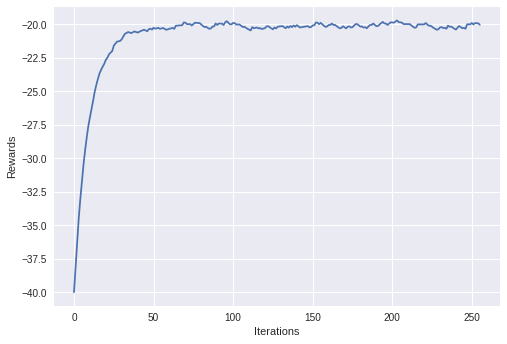

In [0]:
pong_model = create_pong_model()
MAX_ITERS = 10000

smoothed_reward = util.LossHistory(smoothing_factor=0.9)
plotter = util.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')

for i_episode in range(MAX_ITERS):

  plotter.plot(smoothed_reward.get())

  # Restart the environment
  observation = env.reset()
  previous_frame = pre_process(observation)


  while True:
      # Pre-process image 
      current_frame = pre_process(observation)

      obs_change = current_frame - previous_frame
      
      action = choose_action(pong_model, obs_change) # Use frame difference 
      next_observation, reward, done, info = env.step(action)
      memory.add_to_memory(obs_change, action, reward) # Save frame difference

      if done:
          total_reward = sum(memory.rewards)
          smoothed_reward.append( total_reward )

          train_step(pong_model, 
                     optimizer, 
                     observations = np.vstack(memory.observations), #FIXME: this is not running for me -- does it work for you? 
                     actions = np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))
          
          memory.clear()
          break

      observation = next_observation
      previous_frame = current_frame

### 2.5: Save and display video of training

We can now save the video of our model learning:

In [0]:
save_video_of_model(pong_model, "Pong-v0", filename='pong_agent.mp4')  

And display the result:

In [0]:
from IPython.display import HTML
import io, base64
video = io.open('./agent2.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))